## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Libraries</p>

In [6]:
!pip install sklego -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os

import lightgbm as lgbm
from lightgbm import log_evaluation, early_stopping, record_evaluation
from sklearn import metrics
from sklearn import model_selection, utils
from sklego.linear_model import LADRegression

import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']


from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
gld = Style.BRIGHT + Fore.YELLOW
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Data</p>

In [7]:
PATH_ORIGIN = '../WildBlueberryPollinationSimulationData.csv'
PATH_TRAIN = '../train.csv'
PATH_TEST = '../test.csv'
PATH_OOFS = '../pubs'
PATH_SUB = '../sample_submission.csv'


def mattop_post_process(preds):
     return np.array([min(unique_targets, key = lambda x: abs(x - pred)) for pred in preds])

class DataProcessor:
    def __init__(self,
                 train_data=None,
                 test_data=None,
                 combined: bool = False,
                 verbose: bool = False):
        self.origin_data = None
        self.train_data = train_data
        self.test_data = test_data
        self.combined = combined
        self.verbose = verbose

    def load_data(self):
        if self.combined:
            # 
            self.origin_data = pd.read_csv(PATH_ORIGIN).drop(columns='Row#').drop([766])
        self.train_data = pd.read_csv(PATH_TRAIN).drop(columns='id')
        self.test_data = pd.read_csv(PATH_TEST).drop(columns='id')

        if self.verbose:
            print(f'{gld}[INFO] Shapes before feature engineering:'
                  f'{gld}\n[+] train  -> {red}{self.train_data.shape}'
                  f'{gld}\n[+] test   -> {red}{self.test_data.shape}\n')

    @staticmethod
    def fe(df):
        return df

    def process_data(self):
        self.load_data()

        self.train_data = self.fe(self.train_data)
        self.test_data = self.fe(self.test_data)

        if self.combined:
            cols = self.train_data.columns
            self.origin_data = self.fe(self.origin_data)
            self.train_data = pd.concat([self.train_data, self.origin_data])
            self.train_data = self.train_data.reset_index(drop=True)

        if self.verbose:
            print(f'{gld}[INFO] Shapes after feature engineering:'
                  f'{gld}\n[+] train  -> {red}{self.train_data.shape}'
                  f'{gld}\n[+] test   -> {red}{self.test_data.shape}\n')

        return self.train_data, self.test_data
          
          
def xy_split(tr_df, te_df, target, cols_to_drop=[]):
    """Preprocess the train and test data by dropping the
    eliminated columns and separating the target column.

        Args:
            tr_df: Train dataframe.
            te_df: Test dataframe.
            target: list of str (target name).
            cols_to_drop: list of str (columns to be eliminated).

        Returns:
            X_tr: X_train dataframe.
            y_tr: y_train pd.Series.
            te_df: test dataframe.
    """
    if cols_to_drop:
        X_tr = tr_df.drop(columns=target + cols_to_drop)
        y_tr = tr_df[target[0]]
        te_df = te_df.drop(columns=cols_to_drop)
    else:
        X_tr = tr_df.drop(columns=target)
        y_tr = tr_df[target[0]]
    return X_tr, y_tr, te_df

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">EXP 2 Model</p>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Model</p>

In [8]:
class LGBMCVModel:
    def __init__(self, cv, **kwargs):
        self.cv = cv
        self.model_params = kwargs
        self.models_ = list()
        self.feature_importances_ = None
        self.eval_results_ = dict()
        self.oof = None
        self.metric = mae
        self.tuning_step = False
        self.mean_cv_score = None
        self.general_config = None
        self.predictions = None
        self.target_name = None

    def fit(self, X, y=None, **kwargs):
        feature_names = X.columns if isinstance(X, pd.DataFrame) else list(range(X.shape[1]))
        self.feature_importances_ = pd.DataFrame(index=feature_names)
        self.oof = np.zeros(len(X))

        for fold, (fit_idx, val_idx) in enumerate(self.cv.split(X, y), start=1):

            # Split the dataset according to the fold indexes.
            X_fit = X.iloc[fit_idx]
            X_val = X.iloc[val_idx]
            y_fit = y.iloc[fit_idx]
            y_val = y.iloc[val_idx]

            # LGBM .train() requires lightgbm.Dataset.
            # https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.Dataset
            fit_set = lgbm.Dataset(X_fit, y_fit)
            val_set = lgbm.Dataset(X_val, y_val)

            # Training.
            # https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.train
            self.eval_results_[fold] = {}
            model = lgbm.train(
                params=self.model_params,
                train_set=fit_set,
                valid_sets=[fit_set, val_set],
                valid_names=['fit', 'val'],
                callbacks=[
                    log_evaluation(0),
                    record_evaluation(self.eval_results_[fold]),
                    early_stopping(self.model_params['early_stopping_rounds'],
                                   verbose=False, first_metric_only=True)
                ],
                **kwargs
            )

            val_preds = model.predict(X_val)
            self.oof[val_idx] += val_preds / self.general_config['N_REPEATS']

            if not self.tuning_step:
                val_score = self.metric(y_val, val_preds)
                best_iter = model.best_iteration
                print(f'Fold: {blu}{fold:>3}{res}| {self.metric.__name__}: {blu}{val_score:.5f}{res}'
                      f' | Best iteration: {blu}{best_iter:>4}{res}')

                # Stores the model
                self.models_.append(model)

        self.mean_cv_score = self.metric(y, self.oof)
        print(f'{"*" * 50}\n{red}Mean{res} {self.metric.__name__}: {red}{self.mean_cv_score:.5f}')
        return self
    
    def predict(self, X):
        utils.validation.check_is_fitted(self, ['models_'])

        y = np.zeros(len(X))
        for model in tqdm(self.models_):
            y += model.predict(X)

        return y / len(self.models_)

In [9]:
###############################################################
# CFG and metric.
###############################################################
config = {"SEED": 42,
          "FOLDS": 10,
          "N_ESTIMATORS": 2000,
          "EXP_NUM": "2",
          "COMBINE": True,
          "KFOLD": True,
          'N_REPEATS': 3,
          "COL_DROP": ["RainingDays"]}
          
params = {"learning_rate": 0.04,
          "max_bin": 1000,
          "colsample_bytree": 0.8,
          "subsample": 0.7,
          "bagging_freq": 1,
          "objective": "regression_l1",
          "metric": "mae",
          "early_stopping_rounds": 200,
          "n_jobs": -1,
          "verbosity": -1}
   
def mae(y_true, y_pred):
    return metrics.mean_absolute_error(y_true, y_pred)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Training</p>

In [10]:
target = ['yield']
f_e = DataProcessor(verbose=True, combined=config['COMBINE'])
train, test = f_e.process_data()
X_train, y_train, test = xy_split(train, test, target, cols_to_drop=config['COL_DROP'])

cv = model_selection.RepeatedKFold(n_repeats=config['N_REPEATS'],
                                   n_splits=config['FOLDS'],
                                   random_state=config['SEED'])

lgbm_model = LGBMCVModel(cv=cv,  **params)
lgbm_model.tuning_step = False
lgbm_model.general_config = config
lgbm_model.target_name = target[0]
lgbm_model.fit(X_train, y_train, num_boost_round=config['N_ESTIMATORS'])
mae_full = lgbm_model.mean_cv_score
mae_true = mae(y_train.iloc[:15289], lgbm_model.oof[:15289])
print(f'{mae_full=}\n{mae_true=}')

[INFO] Shapes before feature engineering:
[+] train  -> (15289, 17)
[+] test   -> (10194, 16)

[INFO] Shapes after feature engineering:
[+] train  -> (16065, 17)
[+] test   -> (10194, 16)

Fold:   1| mae: 327.26636 | Best iteration:  973
Fold:   2| mae: 329.97535 | Best iteration:  977
Fold:   3| mae: 338.67910 | Best iteration:  565
Fold:   4| mae: 312.58037 | Best iteration: 1141
Fold:   5| mae: 340.06956 | Best iteration:  241
Fold:   6| mae: 323.28795 | Best iteration: 1142
Fold:   7| mae: 328.90566 | Best iteration:  860
Fold:   8| mae: 319.99471 | Best iteration:  900
Fold:   9| mae: 326.32873 | Best iteration:  446
Fold:  10| mae: 330.12770 | Best iteration: 1116
Fold:  11| mae: 329.45549 | Best iteration:  899
Fold:  12| mae: 323.92569 | Best iteration:  557
Fold:  13| mae: 328.16373 | Best iteration: 1421
Fold:  14| mae: 343.05083 | Best iteration:  937
Fold:  15| mae: 317.93376 | Best iteration:  594
Fold:  16| mae: 326.46886 | Best iteration: 1114
Fold:  17| mae: 331.55753 |

In [11]:
path_submissions = ''
exp_num = '2'

oof = pd.DataFrame(lgbm_model.oof[:15289], columns=['oof_preds'])
oof.to_csv(os.path.join(path_submissions, f'oof_{exp_num}.csv'), index=False)

# Saves the submission file.
submission = pd.read_csv(PATH_SUB)
if lgbm_model.predictions is None:
    predictions = lgbm_model.predict(test)
else:
    predictions = lgbm_model.predictions
submission[lgbm_model.target_name] = predictions
submission.to_csv(os.path.join(path_submissions, f'submission.csv'), index=False)

  0%|          | 0/30 [00:00<?, ?it/s]

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Ensemble</p>

In [12]:
origin = pd.read_csv(PATH_ORIGIN)
train = pd.read_csv(PATH_TRAIN)
test = pd.read_csv(PATH_TEST)
target_name = ['yield']
target = train[target_name[0]]
unique_targets = np.unique(train["yield"])

oofs_df = pd.DataFrame()
subs_df = pd.DataFrame()
MATT = True

# this can be paralleled... 
# reads public oofs and submissions + exp 2 model above.
# stores those records in two dataframes.
for i in tqdm([1, 2, 4, 5, 6, 7, 8]):
    pub_oof = pd.read_csv(f'{PATH_OOFS}/p{i}_oof.csv').iloc[:15289, :]
    sub_oof = pd.read_csv(f'{PATH_OOFS}/p{i}_sub.csv')
    if MATT:
        oofs_df[f'p{i}'] = mattop_post_process(pub_oof.oof_preds)
        subs_df[f'p{i}'] = mattop_post_process(sub_oof[target_name[0]])
    else:
        oofs_df[f'p{i}'] = pub_oof.oof_preds
        subs_df[f'p{i}'] = sub_oof[target_name[0]]


if MATT:
    oofs_df[f's{exp_num}'] = mattop_post_process(oof.oof_preds)
    subs_df[f's{exp_num}'] = mattop_post_process(submission[target_name[0]])
else: 
    oofs_df[f's{exp_num}'] = oof.oof_preds
    subs_df[f's{exp_num}'] = submission[target_name[0]]
        
oofs_df

  0%|          | 0/7 [00:00<?, ?it/s]

,p1,p2,p4,p5,p6,p7,p8,s2
0,4546.78674,4558.98072,4558.98072,4546.78674,4558.98072,4546.78674,4558.98072,4580.39300
1,4975.88538,4968.60117,4999.15621,4999.15621,4975.88538,4924.35736,4930.61903,4999.15621
2,6731.61844,6696.23571,6717.44627,6628.76363,6696.23571,6671.07264,6702.78038,6696.23571
3,6880.77590,6862.90839,6880.77590,6901.65894,6869.77760,6862.90839,6870.34212,6860.39643
4,7028.67350,7198.42285,7136.98445,7085.06308,6852.97971,7222.00462,7243.22611,7136.98445
...,...,...,...,...,...,...,...,...
15284,7230.13250,7230.13250,7231.02778,7267.28344,7234.25525,7290.10652,7301.10622,7150.98170
15285,3519.43131,3519.43131,3519.43131,3494.94296,3626.36653,3626.36653,3626.36653,3626.36653
15286,4503.16186,4460.91457,4503.16186,4546.78674,4503.16186,4546.78674,4580.39300,4433.53697
15287,6628.76363,6583.45789,6638.65649,6554.97686,6608.04163,6708.24129,6696.23571,6598.85404


In [13]:
for i, col in enumerate(oofs_df.columns):
    score = mae(train[target_name[0]], oofs_df[col])
    print(f'OOF {red}{mae.__name__.upper()}{res} for model {col}: {red}{score:.4f}{res}')

OOF MAE for model p1: 338.9011
OOF MAE for model p2: 338.3369
OOF MAE for model p4: 338.4783
OOF MAE for model p5: 337.1758
OOF MAE for model p6: 341.9375
OOF MAE for model p7: 339.0152
OOF MAE for model p8: 339.2103
OOF MAE for model s2: 337.2781


In [14]:
LADRegression_blend = LADRegression(positive=True)
LADRegression_blend.fit(oofs_df, train[target_name[0]])
lad_score = mae(train[target_name[0]], LADRegression_blend.predict(oofs_df))
print(f"{blk}MAE with LAD Regression of OOFS predictions : {red}{lad_score}{blk}\n\nCoefficients :{res}")
display(pd.Series(LADRegression_blend.coef_.round(2), oofs_df.columns, name='weight'))

MAE with LAD Regression of OOFS predictions : 336.2385845796311

Coefficients :


p1    0.07
p2    0.00
p4    0.13
p5    0.40
p6    0.00
p7    0.04
p8    0.13
s2    0.24
Name: weight, dtype: float64

In [15]:
def get_ensemble_csv(df: pd.DataFrame, is_oof: bool = False) -> pd.Series:
    """Ensembles subs or oofs if specified by multiplying
    it by obtained weights from scipy.optimize
    
        Args: 
            df: (subs or oofs)
            is_oof: default subs
        
        Returns:
            ensembled_sub_preds or ensembled_oof_preds
    """
    preds = LADRegression_blend.predict(df)
    
    if is_oof:
        score_post = mae(train[target_name[0]], mattop_post_process(preds))
        print(f"{blk}MAE of OOFS predictions with LAD Regression with repeated mattop_post: {red}{lad_score}{blk}")
    else:
        sub = pd.read_csv(PATH_SUB)
        sub[target_name[0]] = preds
        sub[target_name[0]] = mattop_post_process(preds)
        
        # Manual value correction based on the validation.
        te4503 = test.query('fruitset == 0.433014308 and fruitmass == 0.4228466').index
        te1945 = test.query('fruitset == 0.233554492 and fruitmass == 0.335338738').index
        te8538 = test.query('fruitset == 0.631033926 and fruitmass == 0.520003767').index
        
        te2384 = test.query('fruitset == 0.262139643 and fruitmass == 0.349353787').index
        te3049 = test.query('fruitset == 0.315500071 and fruitmass == 0.367762987').index
        
        sub.loc[te1945, target_name[0]] = 1945.53061
        sub.loc[te4503, target_name[0]] = 4503.16186
        sub.loc[te8538, target_name[0]] = 8538.46200
        
        sub.loc[te2384, target_name[0]] = 2384.72892
        sub.loc[te3049, target_name[0]] = 3049.26032
    return preds

best_oof = get_ensemble_csv(oofs_df, is_oof=True)
best_sub = get_ensemble_csv(subs_df)

MAE of OOFS predictions with LAD Regression with repeated mattop_post: 336.2385845796311


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Hard Correction, Pseudo Leak</p>

In [16]:
# Motivation for value correction
test['preds'] = submission['yield']
train['s2_preds'] = lgbm_model.oof[:15289]
train['s2_errors'] = train['s2_preds'] - train['yield']

print(f'{red}display train most common yield error{res}\n')
# 1945.53061 yield shows the biggest error rate, and fruitmass, fruitset eq 	0.335339	0.233554	 was common only for this yield
# since it inherited the values from origin.
# now we only need to assign correct values and run it for all other examples.
display(train.query('s2_errors > 400')['yield'].value_counts())
display(train.query('`yield` == 1945.53061')[['fruitmass', 'fruitset', 'yield', 's2_preds', 's2_errors']].sort_values(by='fruitmass').head(10))

print(f'\n{red}display origin{res}\n')
display(origin.query('`yield` == 1945.530615')[['fruitmass', 'fruitset', 'yield']])

print(f'\n{red}display test{res}\n')
fs, fm = train.loc[8581, ['fruitset', 'fruitmass']].tolist()

display(test.query('fruitset == @fs and fruitmass == @fm')[['fruitmass', 'fruitset', 'preds']].sort_values(by='fruitmass').head(10))
print(f'\n{red}Do you see what the model assignes for values 0.335339	0.233554... It should be 1945.53061 and there are 6 such examples in test!{res}\n')

display train most common yield error



yield
1945.53061    26
4802.60430    13
2825.00374    12
5018.45303    11
4745.46028    10
              ..
7616.70599     1
5946.05226     1
7639.54789     1
5741.31418     1
3941.25512     1
Name: count, Length: 582, dtype: int64

,fruitmass,fruitset,yield,s2_preds,s2_errors
8581,0.335339,0.233554,1945.53061,2382.109756,436.579146
10792,0.335339,0.233554,1945.53061,2380.867105,435.336495
7520,0.335339,0.233554,1945.53061,2396.945961,451.415351
5456,0.335339,0.233554,1945.53061,2394.537824,449.007214
4419,0.335339,0.233554,1945.53061,2377.717184,432.186574
14880,0.335339,0.233554,1945.53061,2366.795151,421.264541
2075,0.335339,0.233554,1945.53061,2381.383122,435.852512
13551,0.373987,0.379906,1945.53061,3968.886388,2023.355778
9088,0.375616,0.385813,1945.53061,4043.460531,2097.929921
13662,0.380185,0.343963,1945.53061,3304.368575,1358.837965



display origin



,fruitmass,fruitset,yield
18,0.335339,0.233554,1945.530615



display test



,fruitmass,fruitset,preds
2586,0.335339,0.233554,2369.671704
3955,0.335339,0.233554,2376.975251
4899,0.335339,0.233554,2376.975251
5549,0.335339,0.233554,2370.149717
7183,0.335339,0.233554,2394.102984
9276,0.335339,0.233554,2351.479194



Do you see what the model assignes for values 0.335339	0.233554... It should be 1945.53061 and there are 6 such examples in test!



In [17]:
# Let me correct some other manually found interesting examples and see how oof behaves.
tr4503 = train.query('fruitset == 0.433014308 and fruitmass == 0.4228466').index
tr1945 = train.query('fruitset == 0.233554492 and fruitmass == 0.335338738').index
tr8538 = train.query('fruitset == 0.631033926 and fruitmass == 0.520003767').index

tr2384 = train.query('fruitset == 0.262139643 and fruitmass == 0.349353787').index
tr3049 = train.query('fruitset == 0.315500071 and fruitmass == 0.367762987').index

cop = pd.Series(mattop_post_process(best_oof.copy()))
cop.loc[tr1945] = 1945.53061
cop.loc[tr4503] = 4503.16186
cop.loc[tr8538] = 8538.46200

cop.loc[tr2384] = 2384.72892
cop.loc[tr3049] = 3049.26032

score_post = mae(train[target_name[0]], mattop_post_process(best_oof))
print(f'{red}{mae.__name__.upper()}{res} for model best_oof post:                  {red}{score_post:.4f}{res}')
score_post = mae(train[target_name[0]], cop)
print(f'{red}{mae.__name__.upper()}{res} for model best_oof post with corrections: {red}{score_post:.4f}{res}')

MAE for model best_oof post:                  336.1373
MAE for model best_oof post with corrections: 335.8963


In [18]:
test['pred'] = best_sub
train['pred'] = cop

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Postprocessing phase 2, Automating Hard Corrections</p>

In [19]:
from joblib import Parallel, delayed

ddf = pd.read_csv('/kaggle/input/s3e14-oofs/ffs.csv')
grp = ddf.groupby(by='ffs').last().sort_values(by='score')

def second_postprocessing(indx: str):
    """Walks thru grouped ffs.csv file fetching `fruitmass_fruitset`
    as indx (0.334593591_0.379871916) and splits it.    
    
    The idea was to assign the best performing value (last in `grp`) from ffs.csv
    but original value performed better and was robust.
    
        Args:
            indx: str of 'fruitmass_fruitset' (example: 0.334593591_0.379871916)
        
        Returns:
            tr_idx, te_idx, orig_value - the respective indexes of train/test `yeild` to be corrected.
            None if dangerous zone condition is not satisfied.
    """
    txt = indx
    txt = list(map(float, txt.split('_')))
    dsp_origin = origin.query('fruitset == @txt[0] and fruitmass == @txt[1]')
    dsp_train = train.query('fruitset == @txt[0] and fruitmass == @txt[1]').iloc[:, 7:]
    dsp_test = test.query('fruitset == @txt[0] and fruitmass == @txt[1]').iloc[:, 6:]
    
    # Dangerous zone params:
    if len(dsp_train) > 2 and len(dsp_test) > 1:
        if not dsp_origin.empty:
            orig_value = dsp_origin['yield'].values[0]
            tr_idx = train.loc[train.fruitset.eq(txt[0]) & train.fruitmass.eq(txt[1]), 'pred'].index.tolist()
            te_idx = test.loc[test.fruitset.eq(txt[0]) & test.fruitmass.eq(txt[1]), 'pred'].index.tolist()
            return tr_idx, te_idx, orig_value
    else:
        return None
            
tridx_teidx_value_to_assign = Parallel(n_jobs=-1)(delayed(second_postprocessing)(indx) for indx in tqdm(grp.index))
# Removes Nones from the list.
tridx_teidx_value_to_assign = [i for i in tridx_teidx_value_to_assign if i is not None]

# Corrects the yield values based on the found original values
num_of_tr_rows_affected = 0
num_of_te_rows_affected = 0
for i in tridx_teidx_value_to_assign:
    tr_idx, te_idx, orig_value = i
    
    train.loc[tr_idx, 'pred'] = orig_value
    test.loc[te_idx, 'pred'] = orig_value
    num_of_tr_rows_affected += len(tr_idx)
    num_of_te_rows_affected += len(te_idx)
    
new_score = mae(train[target_name[0]], train['pred'])
print(f'{red}MAE {blk}dangerous zone:        {red}{new_score:.4f}{res}')
print(f'{blk}Number of rows affected train: {red}{num_of_tr_rows_affected}{res}')
print(f'{blk}Number of rows affected test:   {red}{num_of_te_rows_affected}{res}')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/s3e14-oofs/ffs.csv'

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Result Validation</p>

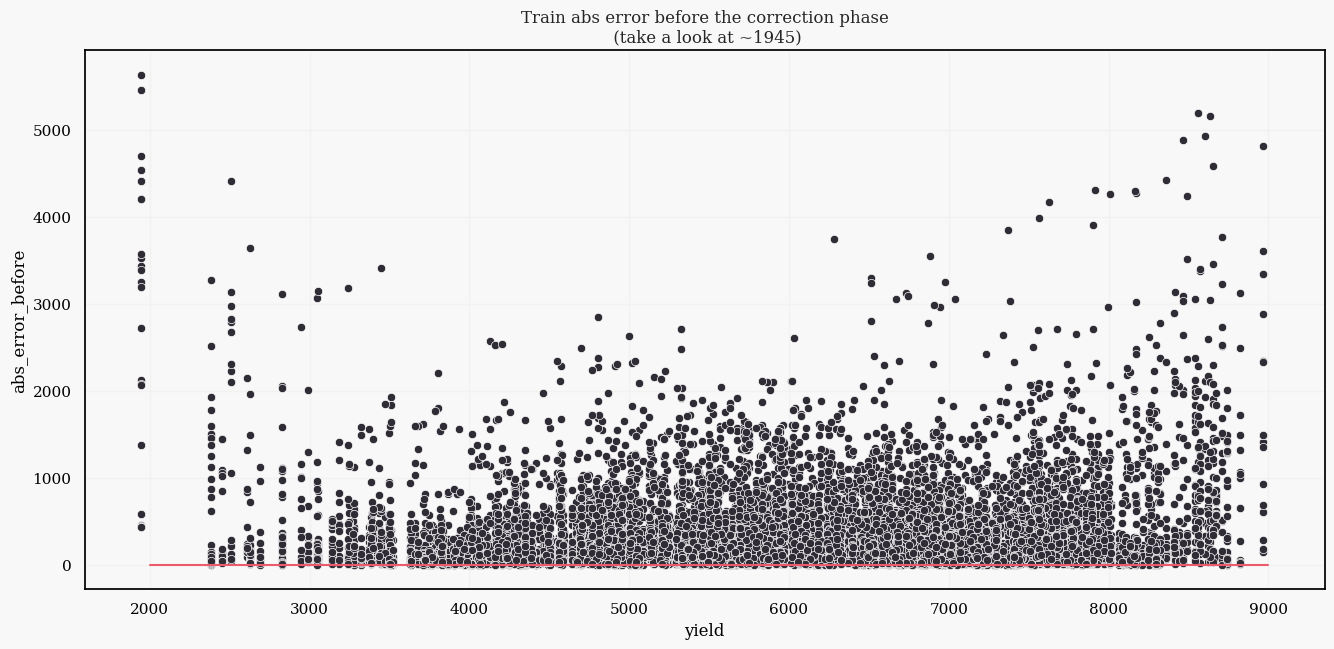

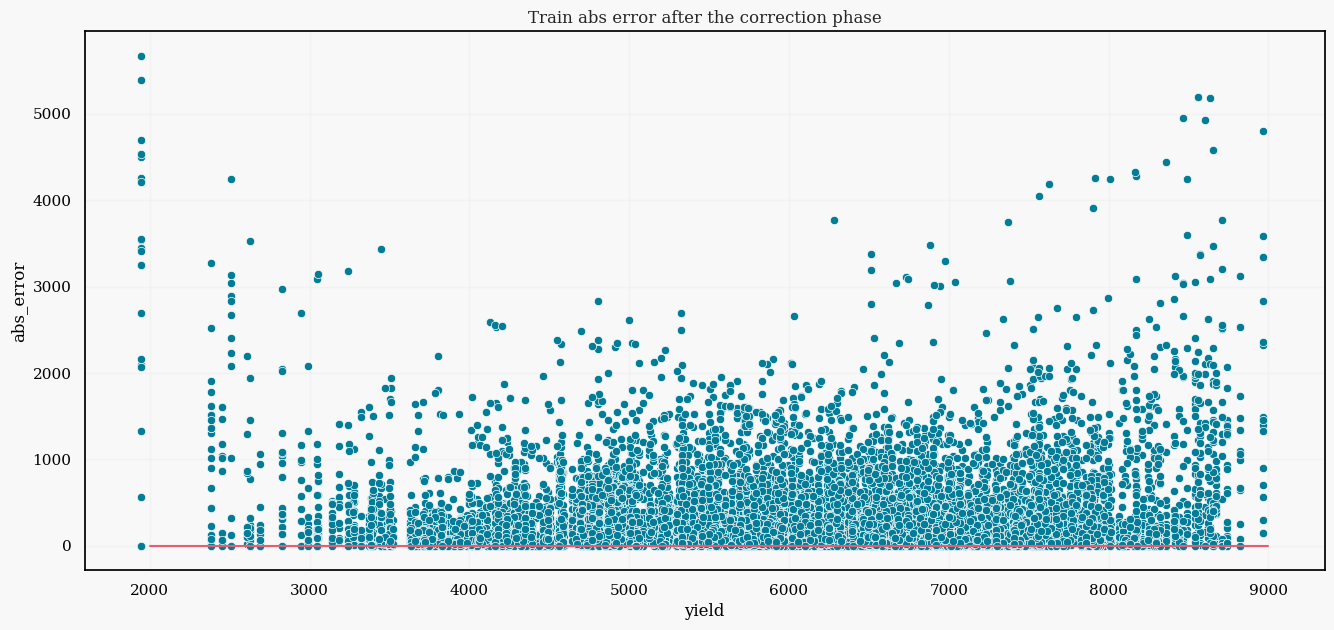

In [ ]:
train['pred_before'] = oof
train['error_before'] = train['yield'] - train.pred_before
train['abs_error_before'] = abs(train['yield'] - train.pred_before)
plt.figure(figsize=(16, 7))
sns.scatterplot(data=train, x='yield', y='abs_error_before', color=palette[0])
sns.lineplot(x=[2000, 9000], y=[0, 0], color=palette[4])
plt.title('Train abs error before the correction phase\n (take a look at ~1945)')
plt.show()

train['error'] = train['yield'] - train.pred
train['abs_error'] = abs(train['yield'] - train.pred)
plt.figure(figsize=(16, 7))
sns.scatterplot(data=train, x='yield', y='abs_error', color=palette[1])
sns.lineplot(x=[2000, 9000], y=[0, 0], color=palette[4])
plt.title('Train abs error after the correction phase')
plt.show()

R_squared: 0.824079
MAE:     333.703209


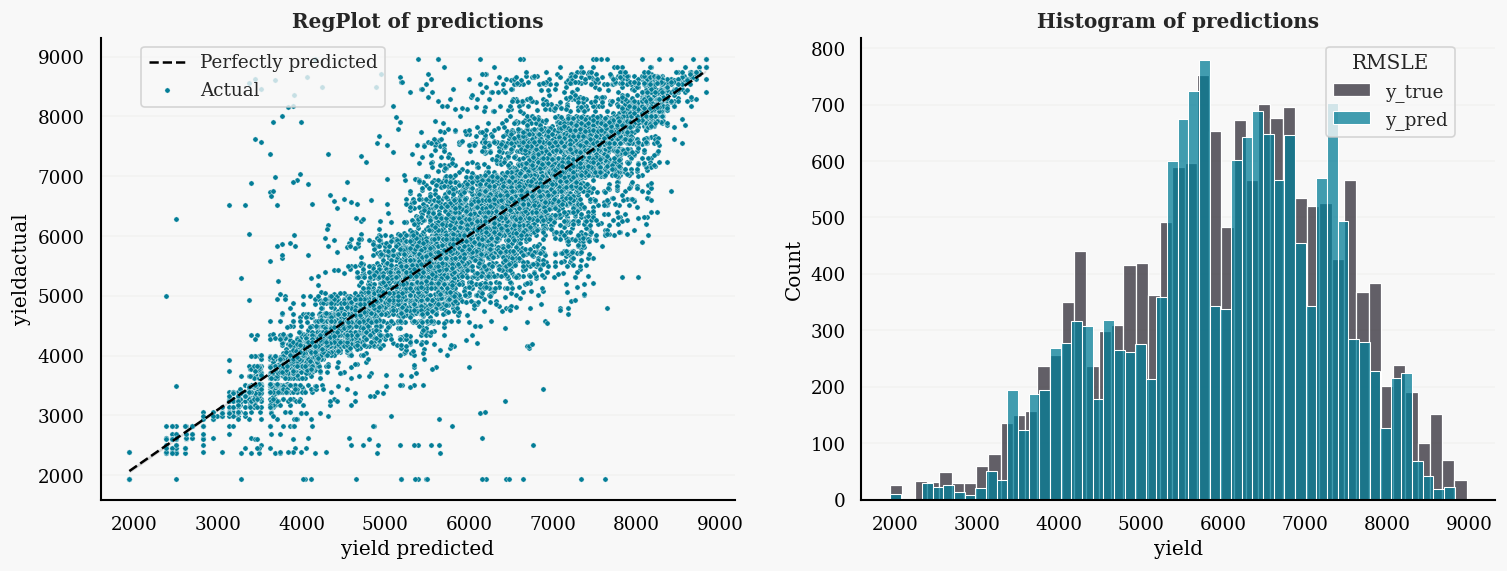

In [ ]:
best_oof = mattop_post_process(train.pred)
r2 = metrics.r2_score(train[target_name[0]], best_oof)
print(f'{blk}R_squared: {red}{r2:.6f}{res}')
print(f'{blk}MAE:     {red}{mae(train[target_name[0]], best_oof):.6f}{res}')

oof_df = pd.DataFrame(np.vstack([best_oof, train[target_name[0]]]).T, columns=[f'{target_name[0]}_pred', target_name[0]])
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=120)
ax = ax.flatten()
sns.regplot(data=oof_df, x=f'{target_name[0]}_pred', y=target_name[0], color=palette[1], scatter=False,
            line_kws={"color": "black", "linestyle": "--", "lw": 1.5}, ax=ax[0], label='Perfectly predicted')

sns.scatterplot(data=oof_df, x=f'{target_name[0]}_pred', y=target_name[0], s=10, color=palette[1], ax=ax[0], label='Actual')

ax[0].legend(bbox_to_anchor=(0.05, 1), loc='upper left')
ax[0].set(xlabel=f'{target_name[0]} predicted', ylabel=f'{target_name[0]}actual')

sns.histplot(oof_df[target_name[0]], color=palette[0], label='y_true', ax=ax[1])
sns.histplot(oof_df[f'{target_name[0]}_pred'], color=palette[1], label='y_pred', ax=ax[1])
ax[1].legend(bbox_to_anchor=(0.95, 1), loc='upper right', title='RMSLE')
for i, _ in enumerate(ax):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].xaxis.grid(False)
    ax[i].yaxis.grid(True)
    
ax[0].set_title(f'RegPlot of predictions', fontdict={'fontweight': 'bold'})
ax[1].set_title(f'Histogram of predictions', fontdict={'fontweight': 'bold'});

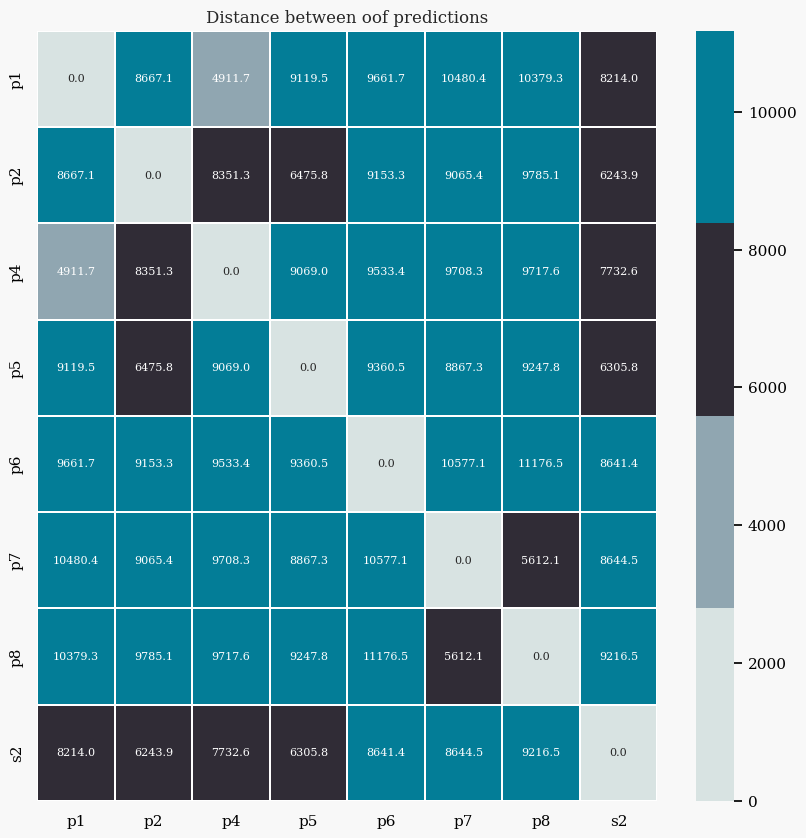

In [ ]:
from scipy.spatial.distance import pdist, squareform
import pandas as pd

# compute pairwise Euclidean distances between columns
distances = squareform(pdist(oofs_df.T, metric='euclidean'))  

plt.figure(figsize=(10, 10))
plt.title('Distance between oof predictions')
sns.heatmap(distances, linewidth=0.1, fmt='.1f', 
            annot=True, annot_kws={'size': 8}, 
            cmap=palette[5:][::-2] + palette[0:2],
            xticklabels=oofs_df.columns,
            yticklabels=oofs_df.columns,
           )
plt.show()

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Final Submission</p>

In [ ]:
s = pd.read_csv(PATH_SUB)
s['yield'] = test.pred
s.to_csv(f'submission_LAD_private_600.csv', index=False)
display(test.pred.to_frame())
display(test.pred.isna().sum())
display(train.pred.isna().sum())

,pred
0,4292.997881
1,5900.767891
2,7268.678183
3,4503.161856
4,3828.165560
...,...
10189,5400.759853
10190,5614.575115
10191,6487.095915
10192,4404.015071


0

0